In [15]:
# Mongo 연결
from pymongo import MongoClient as mc
import random
import pprint as pp

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)

keti_pr_db = client.keti_pattern_recognition
household_col = keti_pr_db.household_info

total = household_col.count()
db_datas = {}
n_total = 20
for n in range(0, n_total):
    ran_datas = list(household_col.\
                find().skip(random.randrange(0,total)).limit(1))[0]
    
    if ran_datas['uid'] not in db_datas:
        db_datas[ran_datas['uid']] = ran_datas

client.close()

<ipython-input-15-94a471b26ff3>:12: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  total = household_col.count()


In [16]:
# require module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

# custom module
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import custom.supports as sp
import custom.mapgenerator as mg
import custom.dateutils as du

SEASONS = {
    "봄" : [3, 4, 5],
    "여름" : [6, 7, 8],
    "가을" : [9, 10, 11],
    "겨울" : [12, 1, 2]
}

SEASONSARR = ['봄','여름','가을','겨울']

'''
 0 : 봄
 1 : 여름
 2 : 가을
 3 : 겨울
'''

# Day Split
DAYARR = ["월", "화", "수", "목", "금", "토", "일"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
dict_data = {}

for uid in db_datas.keys():
    uid, timeslot = db_datas[uid]['uid'], db_datas[uid]['timeslot']
    
    datelist = [
        dt.strptime(ts['time'], "%Y-%m-%d T%H:%M %z").date()
        for ts in timeslot
    ]
    datelist = list(set(datelist))
    datelist.sort()

    ts_datas = {}
    start_idx = 0
    end_idx = 96
    
    for date in datelist:
        ts_datas[date] = [ ts['power'] for ts in timeslot[start_idx:end_idx]]
        start_idx = end_idx
        end_idx = end_idx + 96
        
    ts_datas = pd.DataFrame(ts_datas).T
    datas = ts_datas.reset_index().copy()
    
    datas.rename(columns={"index": "date"}, inplace=True)
    datas['date'] = pd.to_datetime(datas['date'])
    datas['month'] = [dt.month for dt in datas['date']]
    datas = [
        datas[(datas['month'].isin(SEASONS[season]))].copy()
        for season in SEASONSARR
    ]
    
    season_datas = {}
    for season_idx, season in enumerate(SEASONSARR):
        season_datas[season] = datas[season_idx].copy()
    dict_data[uid] = season_datas

20가구에 대하여 비교하고 싶은 계절을 입력해주세요.
(봄/여름/가을/겨울)여름


<AxesSubplot:xlabel='x', ylabel='y'>

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


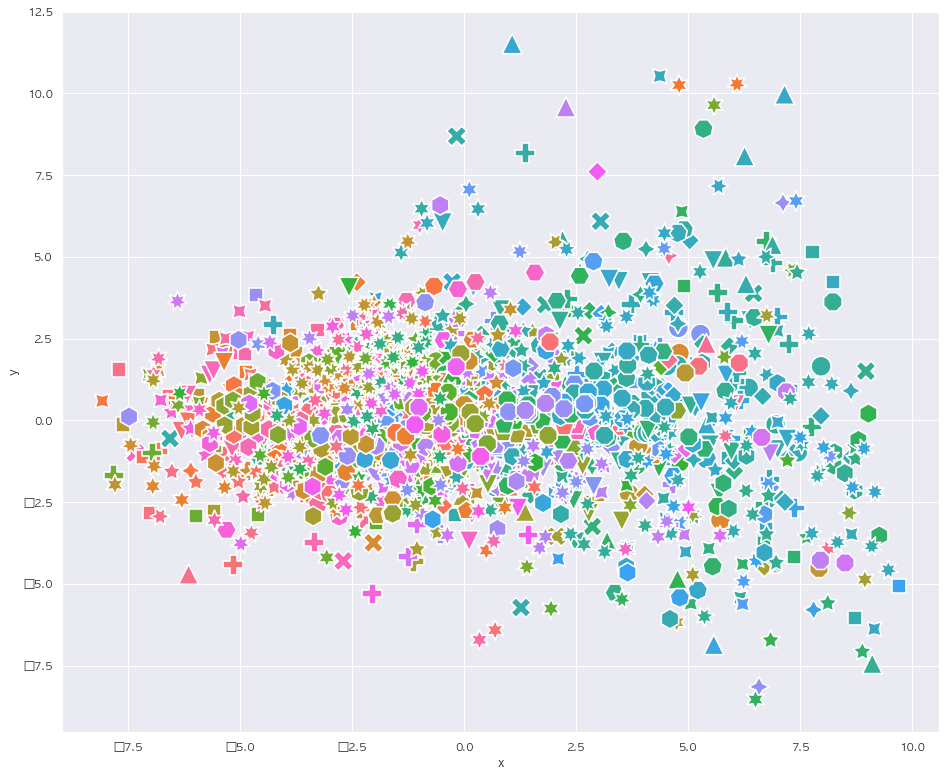

In [75]:
season = input("""{}가구에 대하여 비교하고 싶은 계절을 입력해주세요.
(봄/여름/가을/겨울)""".format(n_total))

scaler = StandardScaler()
all_datas = pd.DataFrame()
bak = ''
for uid in dict_data.keys():
    in_datas = pd.DataFrame()
    datas = dict_data[uid][season]\
        [dict_data[uid][season]
             .columns.difference(['month', 'date'])].copy()
    datas = pd.DataFrame(scaler.fit_transform(datas))
    datas['date'] = pd.to_datetime(dict_data[uid][season]['date'].values)
    datas['uid'] = uid
    all_datas = pd.concat([all_datas, datas])
    bak = uid

all_datas.set_index(['uid', 'date'], inplace=True)
outlier = sp.remove_outlier(all_datas)
rmout_datas = all_datas.loc[
        ~all_datas.index.isin(outlier)
    ].copy()

pca_datas = sp.get_kmeans_pca(rmout_datas)
pca_datas

sns.scatterplot(data=pca_datas, x="x", y="y",
                    hue="date",style="uid", s=400, legend=False)

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


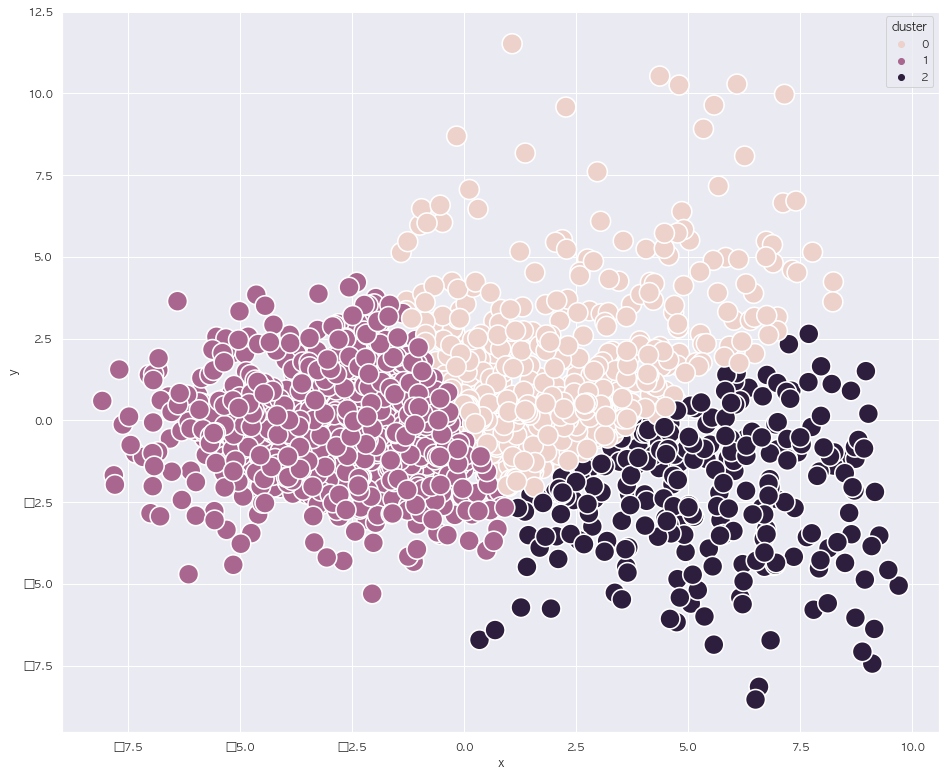

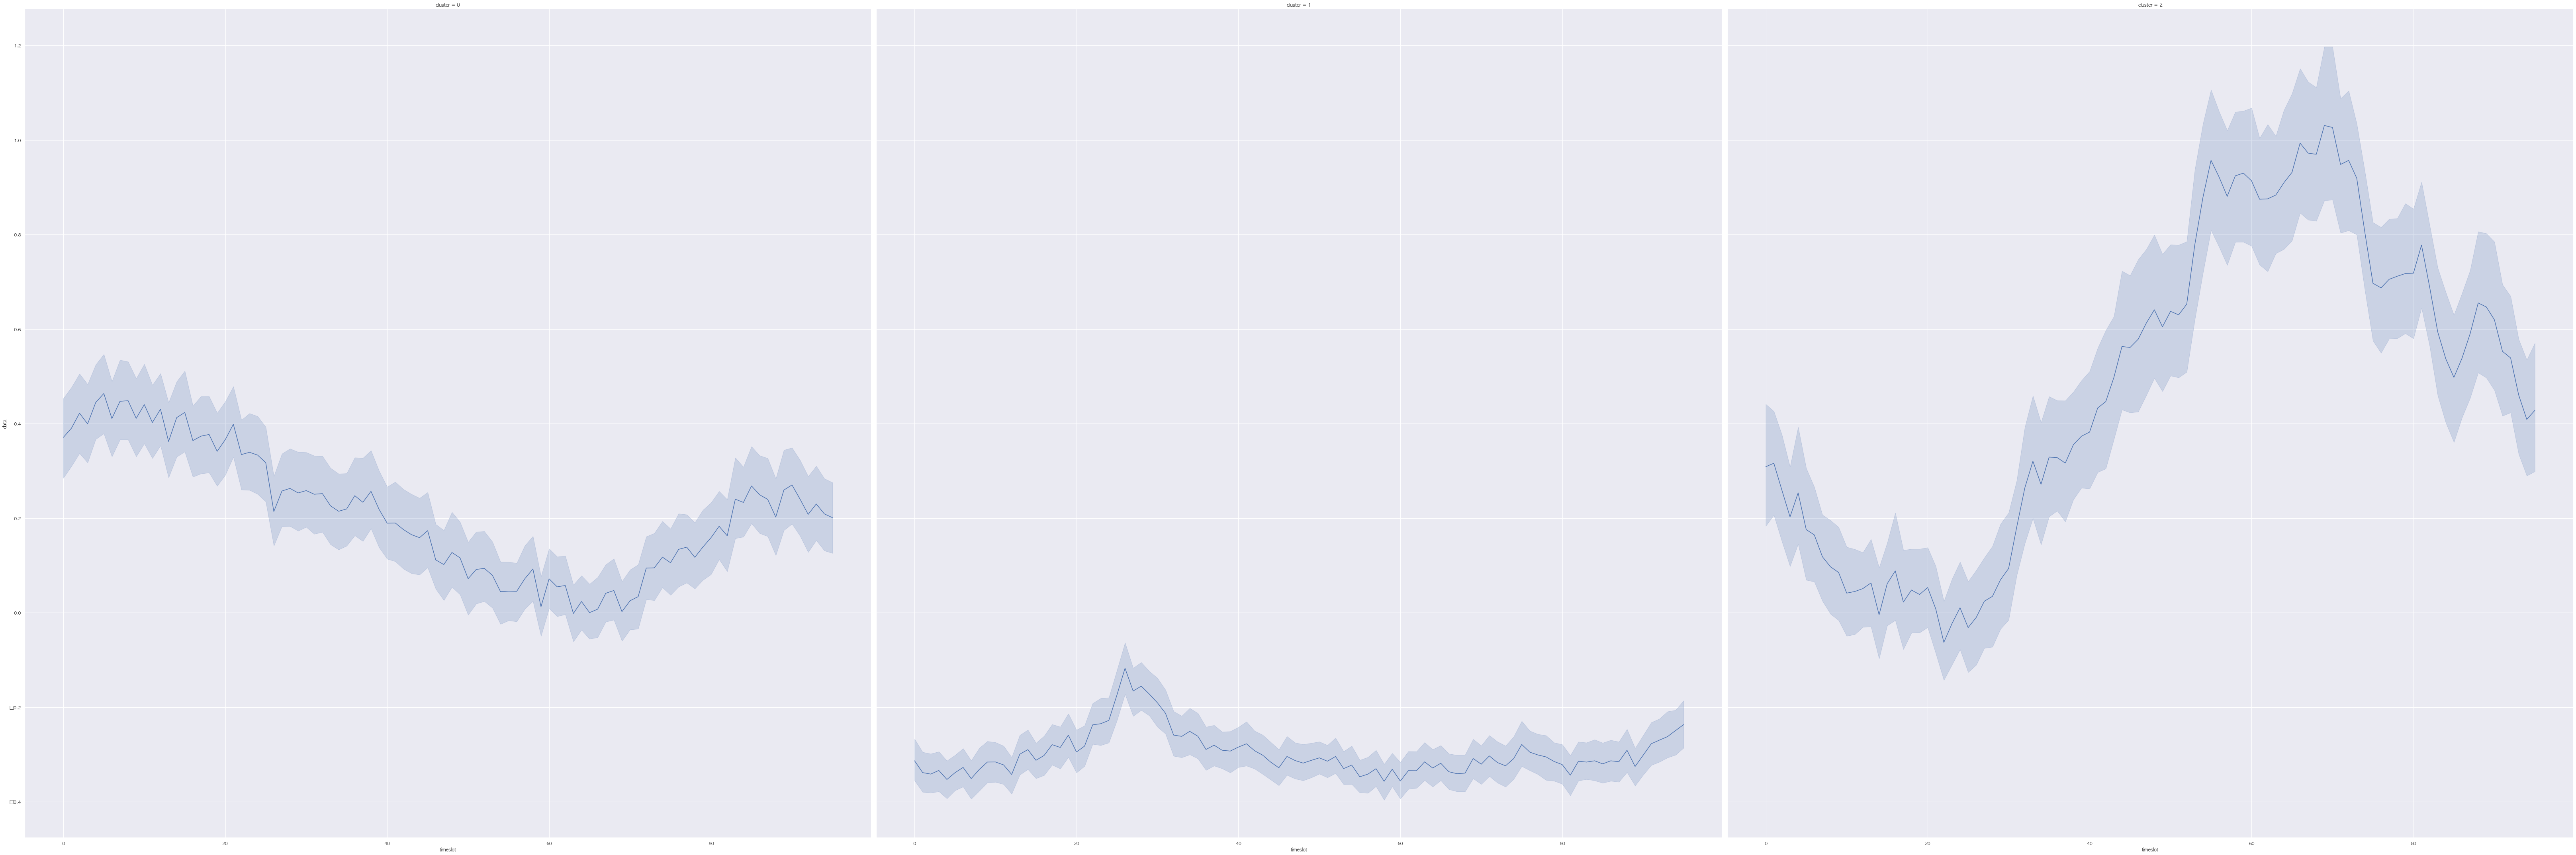

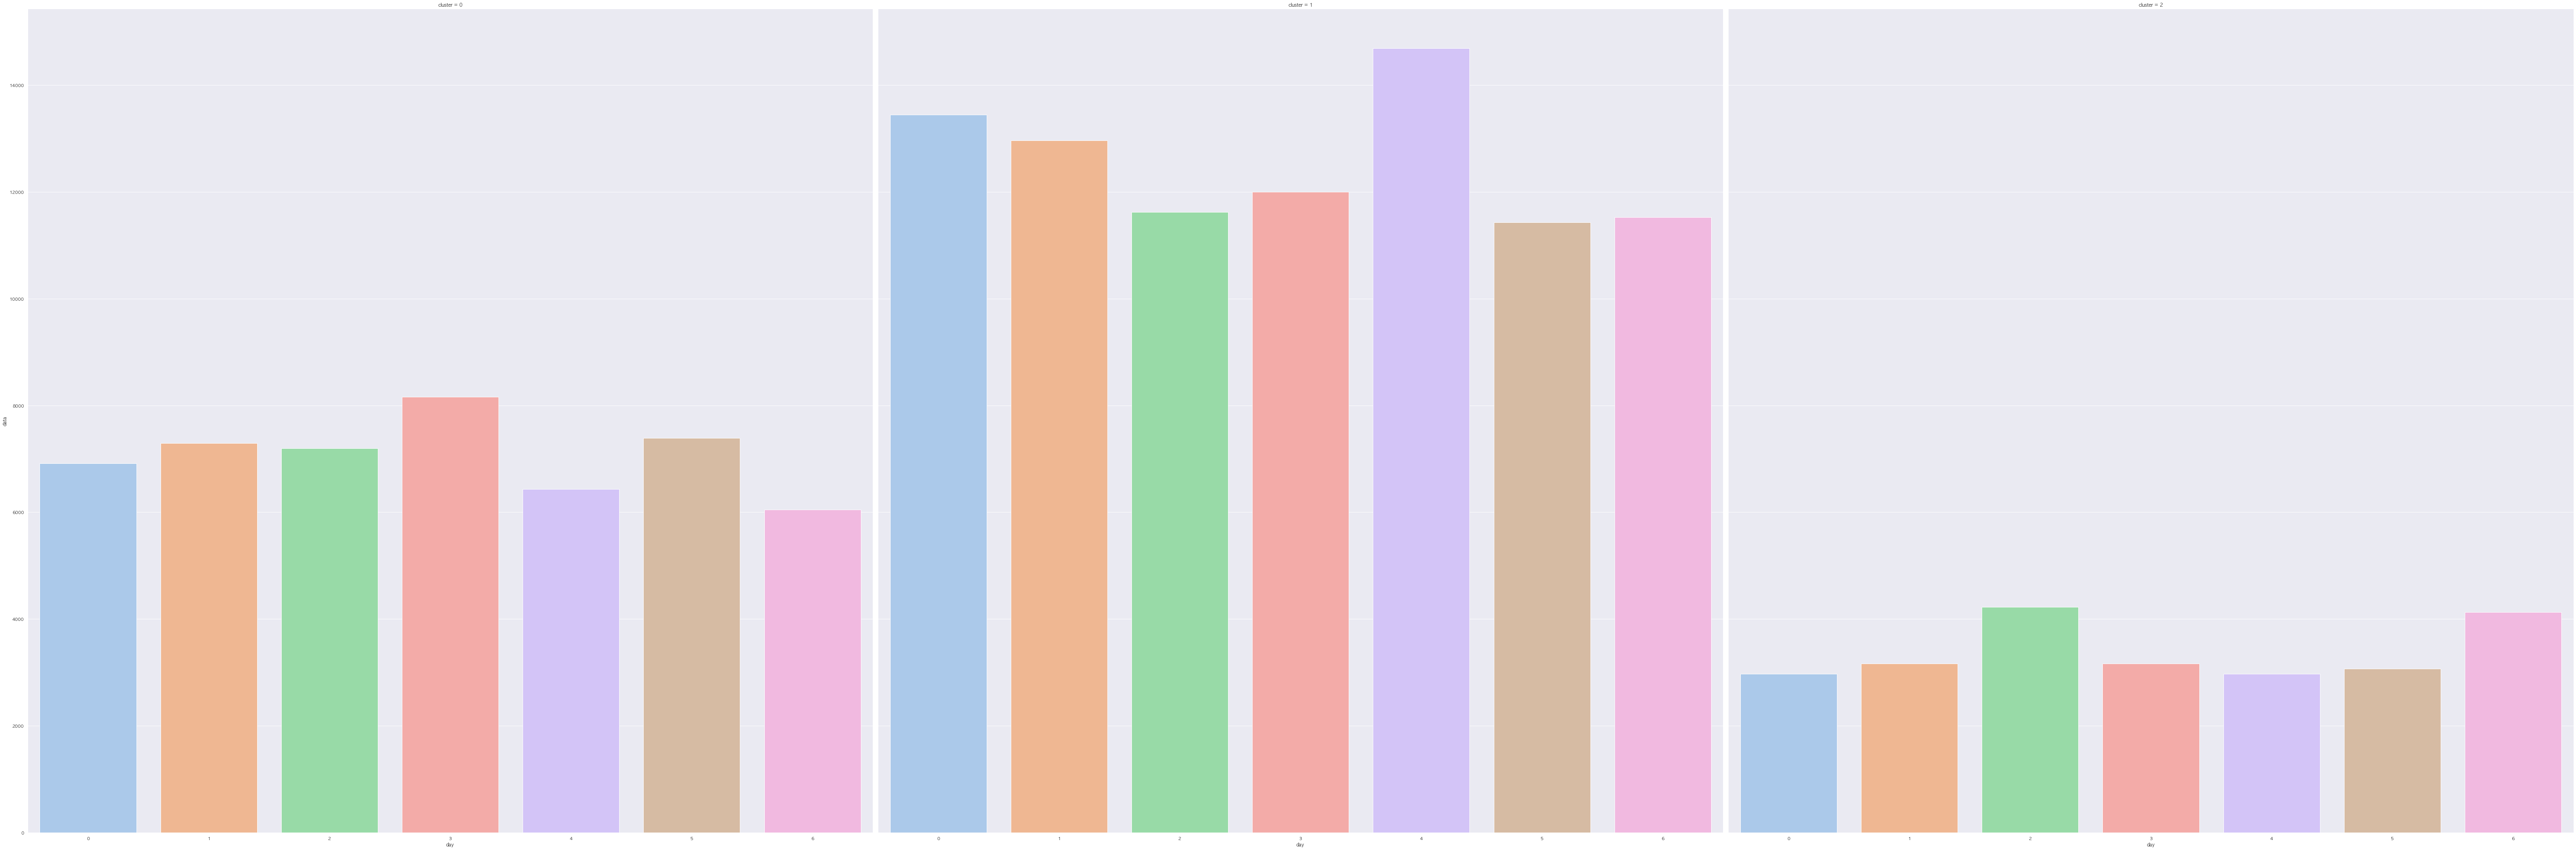

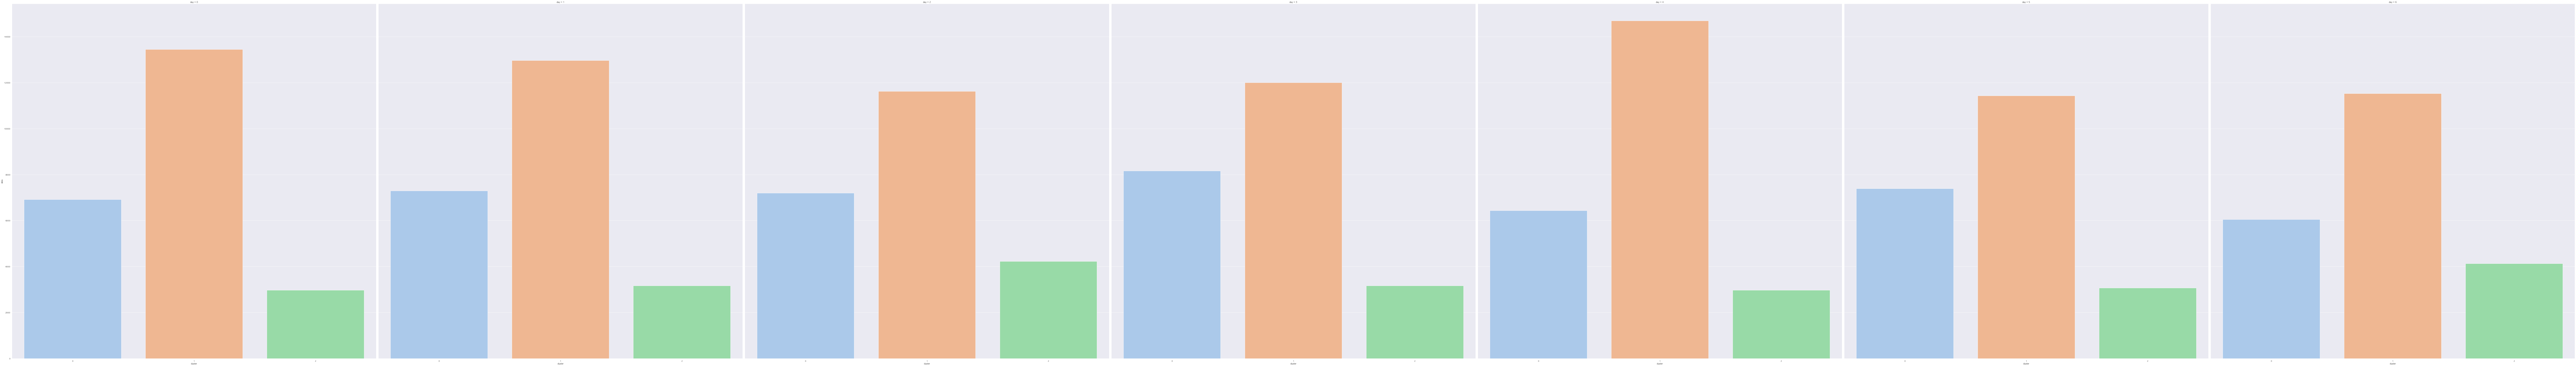

In [76]:
kmeans_points = pca_datas[['x','y']].values
K, k_range, inertia_arr = sp.elbow_k_check(15, kmeans_points)

cluster_pca_datas,\
    cluster_info = sp.run_kmeans(K, pca_datas, rmout_datas)

# Day Append
cluster_map_datas = mg.get_map_datas_cluster(season_datas,rmout_datas, cluster_info)
cluster_map_datas['day'] = cluster_map_datas['date'].dt.weekday
cluster_map_datas['day_kr'] = [du.day_to_kr(day) for day in cluster_map_datas['day']]

# Visualization
sns.scatterplot(data=cluster_pca_datas, x="x", y="y",
           hue="cluster", s=400)

# cluster_line_map = sns.FacetGrid(cluster_map_datas, col='cluster', col_wrap=K, height=30)
# cluster_line_map.map(sns.lineplot, "timeslot","data","date")

cluster_line_map = sns.FacetGrid(cluster_map_datas, col='cluster', col_wrap=K, height=30)
cluster_line_map.map(sns.lineplot, "timeslot","data")

statistic_datas = sp.get_statistic_cluster_datas(cluster_map_datas)
statistic_datas['day'] = [ du.kr_to_day(kr) for kr in statistic_datas['day_kr']]

cluster_bar_map = sns.FacetGrid(statistic_datas, col='cluster', col_wrap=7, height=30)
cluster_bar_map.map(sns.barplot, "day", "data", palette="pastel")
cluster_bar_map = sns.FacetGrid(statistic_datas, col='day', col_wrap=7, height=30)
cluster_bar_map.map(sns.barplot, "cluster", "data", palette="pastel")

In [77]:
# ECV 공식
# 필요변수 
# mean, TSS(Total Sum of Squares), WSS(Within cluster Sum of Squares)
# mean = 전체 데이터 평균
# TSS = 전체 데이터 timeslot과 평균의 timeslot 거리 ^ 2
# WSS = 전체 데이터 timeslot과 전체 데이터의 자신의 main cluster와의 거리
# 필요한 거 : 전체 데이터 timeslot 평균 패턴 ,cluster 패턴 데이터

# 전체 데이터 timeslot 평균 패턴
mean_pattern = []
for ts_idx in range(0, 96):
    mean_pattern.append(cluster_map_datas['data'][ts_idx].mean())
mean_pattern

# cluster 패턴 데이터
cluster_info = pd.DataFrame()
for cluster_num in cluster_map_datas['cluster'].unique():
    cluster_tmp = pd.DataFrame()
    tmp = cluster_map_datas[cluster_map_datas['cluster'] == cluster_num]\
        [['data']].copy()

    cluster_tmp['data'] = [ tmp['data'][idx].mean() for idx in range(0,96) ] 
    cluster_tmp['label'] = cluster_num
    cluster_tmp['timeslot'] = [ idx for idx in range(0,96) ]
    
    cluster_info = pd.concat([cluster_info, cluster_tmp])
    
# TSS
TSS = 0
for uid, date in all_datas.index:
    if len(cluster_map_datas[
            (cluster_map_datas['uid'] == uid) &
            (cluster_map_datas['date'] == date)
        ]) == 0:
        continue
    houself_pattern = all_datas.loc[(uid, date)].values
    TSS += distance.euclidean(mean_pattern,
                      houself_pattern) ** 2
        

# WSS
WSS = 0
for data_idx in all_datas.index:
    pattern_arr = cluster_map_datas[
        ( cluster_map_datas['uid'] == data_idx[0] ) &
        ( cluster_map_datas['date'] == data_idx[1] )
    ]['data'].values
    
    if len(pattern_arr) == 0:
        continue
        
    main_cluster = cluster_map_datas[
        ( cluster_map_datas['uid'] == data_idx[0] ) &
        ( cluster_map_datas['date'] == data_idx[1] )
    ]['cluster'][0]
    
    WSS += distance.euclidean(pattern_arr,
                      cluster_info[
                            cluster_info['label'] == main_cluster
                        ]['data'].values
                      ) ** 2

ECV = 100 * (TSS-WSS) / TSS
print("TSS: {}, WSS: {}".format(TSS, WSS))
print("ECV: {}".format(ECV))

TSS: 176789.99677524916, WSS: 101960.39618485764
ECV: 42.32682954653901
